## VGG-16

### Check GPU

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10574777607658494898
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3365535744
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14620492300019724925
physical_device_desc: "device: 0, name: NVIDIA GeForce 940MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


In [2]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
from keras import backend as K

In [4]:
K.tensorflow_backend._get_available_gpus()

AttributeError: module 'keras.backend' has no attribute 'tensorflow_backend'

### Starting import and applications

In [1]:
import os
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
import numpy as np

In [2]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
#                                      validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

val_generator = ImageDataGenerator(rotation_range=90, 
                                     brightness_range=[0.1, 0.7],
                                     width_shift_range=0.5, 
                                     height_shift_range=0.5,
                                     horizontal_flip=True, 
                                     vertical_flip=True,
#                                      validation_split=0.15,
                                     preprocessing_function=preprocess_input) # VGG16 preprocessing

test_generator = ImageDataGenerator(preprocessing_function=preprocess_input) # VGG16 preprocessing

In [3]:
train_data_dir = 'fruit_data/train'
test_data_dir = 'fruit_data/test'
val_data_dir = 'fruit_data/validation'

In [4]:
traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
#                                                classes=class_subset,
#                                                subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = val_generator.flow_from_directory(val_data_dir,
                                               target_size=(224, 224),
                                               class_mode='categorical',
#                                                classes=class_subset,
#                                                subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(224, 224),
                                             class_mode='categorical',
#                                              classes=class_subset,
                                             batch_size=1,
                                             shuffle=False,
                                             seed=42)

Found 11629 images belonging to 6 classes.
Found 1289 images belonging to 6 classes.
Found 5534 images belonging to 6 classes.


In [5]:
def create_model(input_shape, n_classes, optimizer='rmsprop', fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """
    
    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1072, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [6]:
input_shape = (224, 224, 3)
optim_1 = Adam(learning_rate=0.001)
n_classes=6

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

# First we'll train the model without Fine-tuning
vgg_model = create_model(input_shape, n_classes, optim_1, fine_tune=0)

In [7]:
from livelossplot.inputs.keras import PlotLossesCallback

plot_loss_1 = PlotLossesCallback()

# ModelCheckpoint callback - save best weights
tl_checkpoint_1 = ModelCheckpoint(filepath='tl_model_v1.weights.best.hdf5',
                                  save_best_only=True,
                                  verbose=1)

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

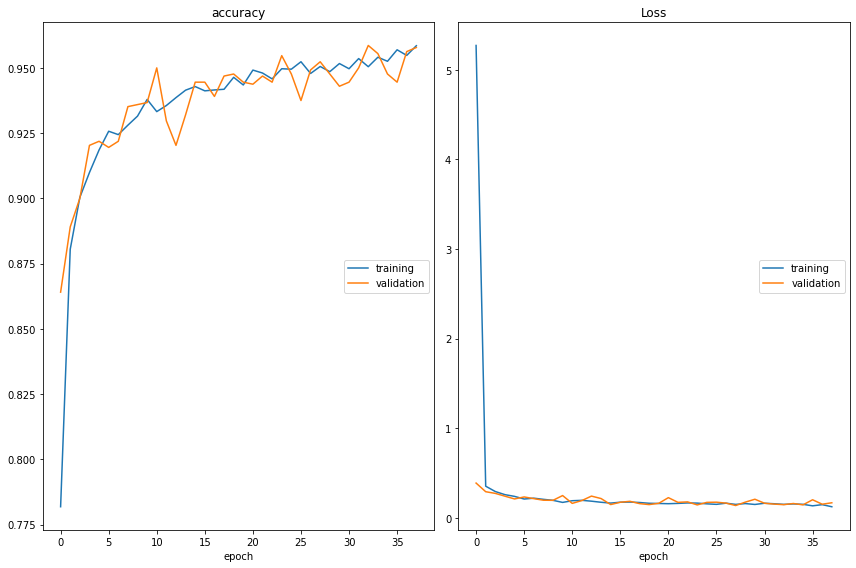

accuracy
	training         	 (min:    0.782, max:    0.958, cur:    0.958)
	validation       	 (min:    0.864, max:    0.959, cur:    0.958)
Loss
	training         	 (min:    0.125, max:    5.271, cur:    0.125)
	validation       	 (min:    0.139, max:    0.389, cur:    0.169)
181/181 [==============================] - 872s 5s/step - loss: 0.1254 - accuracy: 0.9585 - val_loss: 0.1694 - val_accuracy: 0.9578
CPU times: user 3h 43min 35s, sys: 29min 15s, total: 4h 12min 51s
Wall time: 9h 18min 13s


In [8]:
%%time 

vgg_history = vgg_model.fit(traingen,
                            batch_size=BATCH_SIZE,
                            epochs=n_epochs,
                            validation_data=validgen,
                            steps_per_epoch=n_steps,
                            validation_steps=n_val_steps,
                            callbacks=[tl_checkpoint_1, early_stop, plot_loss_1],
                            verbose=1)

In [9]:
# Generate predictions
vgg_model.load_weights('tl_model_v1.weights.best.hdf5') # initialize the best trained weights

true_classes = testgen.classes
class_indices = traingen.class_indices
class_indices = dict((v,k) for k,v in class_indices.items())

vgg_preds = vgg_model.predict(testgen)
vgg_pred_classes = np.argmax(vgg_preds, axis=1)

In [11]:
from sklearn.metrics import accuracy_score

vgg_acc = accuracy_score(true_classes, vgg_pred_classes)
print("VGG16 Model Accuracy without Fine-Tuning: {:.2f}%".format(vgg_acc * 100))

VGG16 Model Accuracy without Fine-Tuning: 96.60%


In [12]:
# Reset our image data generators
traingen.reset()
validgen.reset()
testgen.reset()

# Use a smaller learning rate
optim_2 = Adam(lr=0.0001)

# Re-compile the model, this time leaving the last 2 layers unfrozen for Fine-Tuning
vgg_model_ft = create_model(input_shape, n_classes, optim_2, fine_tune=2)

/home/ankan/.local/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [13]:
%%time

plot_loss_2 = PlotLossesCallback()

# Retrain model with fine-tuning
vgg_ft_history = vgg_model_ft.fit(traingen,
                                  batch_size=BATCH_SIZE,
                                  epochs=n_epochs,
                                  validation_data=validgen,
                                  steps_per_epoch=n_steps, 
                                  validation_steps=n_val_steps,
                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],
                                  verbose=1)

Epoch 1/50


ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/block1_conv1/Conv2D' defined at (most recent call last):
    File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/usr/lib/python3/dist-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/usr/lib/python3/dist-packages/traitlets/config/application.py", line 845, in launch_instance
      app.start()
    File "/usr/lib/python3/dist-packages/ipykernel/kernelapp.py", line 612, in start
      self.io_loop.start()
    File "/usr/lib/python3/dist-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 596, in run_forever
      self._run_once()
    File "/usr/lib/python3.9/asyncio/base_events.py", line 1890, in _run_once
      handle._run()
    File "/usr/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/usr/lib/python3/dist-packages/tornado/ioloop.py", line 688, in <lambda>
      lambda f: self._run_callback(functools.partial(callback, future))
    File "/usr/lib/python3/dist-packages/tornado/ioloop.py", line 741, in _run_callback
      ret = callback()
    File "/usr/lib/python3/dist-packages/tornado/gen.py", line 814, in inner
      self.ctx_run(self.run)
    File "/usr/lib/python3/dist-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 378, in dispatch_queue
      yield self.process_one()
    File "/usr/lib/python3/dist-packages/tornado/gen.py", line 250, in wrapper
      runner = Runner(ctx_run, result, future, yielded)
    File "/usr/lib/python3/dist-packages/tornado/gen.py", line 741, in __init__
      self.ctx_run(self.run)
    File "/usr/lib/python3/dist-packages/tornado/gen.py", line 775, in run
      yielded = self.gen.send(value)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 362, in process_one
      yield gen.maybe_future(dispatch(*args))
    File "/usr/lib/python3/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 265, in dispatch_shell
      yield gen.maybe_future(handler(stream, idents, msg))
    File "/usr/lib/python3/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/lib/python3/dist-packages/ipykernel/kernelbase.py", line 540, in execute_request
      self.do_execute(
    File "/usr/lib/python3/dist-packages/tornado/gen.py", line 234, in wrapper
      yielded = ctx_run(next, result)
    File "/usr/lib/python3/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/usr/lib/python3/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
      return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2886, in run_cell
      result = self._run_cell(
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2932, in _run_cell
      return runner(coro)
    File "/usr/lib/python3/dist-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
      coro.send(None)
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3155, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3347, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 3427, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "<ipython-input-13-a242e2b4b018>", line 1, in <module>
      get_ipython().run_cell_magic('time', '', '\nplot_loss_2 = PlotLossesCallback()\n\n# Retrain model with fine-tuning\nvgg_ft_history = vgg_model_ft.fit(traingen,\n                                  batch_size=BATCH_SIZE,\n                                  epochs=n_epochs,\n                                  validation_data=validgen,\n                                  steps_per_epoch=n_steps, \n                                  validation_steps=n_val_steps,\n                                  callbacks=[tl_checkpoint_1, early_stop, plot_loss_2],\n                                  verbose=1)\n')
    File "/usr/lib/python3/dist-packages/IPython/core/interactiveshell.py", line 2391, in run_cell_magic
      result = fn(*args, **kwargs)
    File "<decorator-gen-54>", line 2, in time
    File "/usr/lib/python3/dist-packages/IPython/core/magic.py", line 187, in <lambda>
      call = lambda f, *a, **k: f(*a, **k)
    File "/usr/lib/python3/dist-packages/IPython/core/magics/execution.py", line 1321, in time
      exec(code, glob, local_ns)
    File "<timed exec>", line 4, in <module>
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/layers/convolutional.py", line 248, in call
      outputs = self.convolution_op(inputs, self.kernel)
    File "/home/ankan/.local/lib/python3.9/site-packages/keras/layers/convolutional.py", line 233, in convolution_op
      return tf.nn.convolution(
Node: 'model_1/block1_conv1/Conv2D'
OOM when allocating tensor with shape[64,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/block1_conv1/Conv2D}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_53257]